In [2]:
import os
import torch
import torchaudio
import pandas as pd
import seaborn as sns

from tqdm.notebook import tqdm
from glob import glob

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [6]:
#PME
df_PME = pd.read_csv('./data/PME/annotations/static_annotations.csv')

#DEAM
df_DEAM1 = pd.read_csv('./data/DEAM/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_1_2000.csv')
df_DEAM2 = pd.read_csv('./data/DEAM/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_2000_2058.csv')
df_DEAM = df_DEAM1.append(df_DEAM2)

#Q4_MER
df_Q4  = pd.read_csv('./data/Q4_MER/panda_dataset_taffc_metadata.csv', encoding = "ISO-8859-1")
if not os.path.isdir('./data/Q4_MER/chorus'):
    os.mkdir('./data/Q4_MER/chorus')

for file in glob('./data/Q4_MER/*/*.mp3'):
    ID = file.split('/')[-1].split('.')[0]
    os.rename(file,'./data/Q4_MER/chorus/{}.mp3'.format(ID))

In [7]:
dic_Q4 = {}
for ID in tqdm(df_Q4['Song'],total=len(df_Q4)):
    try:
        wave_path = './data/Q4_MER/chorus/{}.mp3'.format(ID)
        x = torchaudio.load(wave_path)
        dic_Q4[ID] = x
    except:
        print('Error in ID:',ID)
torch.save(dic_Q4,'data/dic_Q4.pt')

  0%|          | 0/900 [00:00<?, ?it/s]

In [49]:
dic_PME = {}
for ID in tqdm(df_PME['musicId'],total=len(df_PME)):
    ID = str(int(ID))
    try:
        wave_path = './data/PME/chorus/{}.mp3'.format(ID)
        x = torchaudio.load(wave_path)
        dic_PME[ID] = x
    except:
        print('Error in ID:',ID)
torch.save(dic_PME,'data/dic_PME.pt')

  0%|          | 0/767 [00:00<?, ?it/s]

In [24]:
# dic_DEAM = {}
# for ID in tqdm(df_DEAM['song_id'],total=len(df_DEAM)):
#     ID = str(int(ID))
#     try:
#         wave_path = './data/DEAM/MEMD_audio/{}.mp3'.format(ID)
#         x = torchaudio.load(wave_path)
#         dic_DEAM[ID] = x
#     except:
#         print('Error in ID:',ID)
# torch.save(dic_DEAM,'data/dic_DEAM.pt')

  0%|          | 0/1802 [00:00<?, ?it/s]

In [150]:
def Quadrant(df,VA,AR):
    df['label'] = 0
    df['label'] = df['label'].mask((df[VA] >  0.5) & (df[AR] >  0.5),1)
    df['label'] = df['label'].mask((df[VA] <= 0.5) & (df[AR] >  0.5),2)
    df['label'] = df['label'].mask((df[VA] <= 0.5) & (df[AR] <= 0.5),3)
    df['label'] = df['label'].mask((df[VA] >  0.5) & (df[AR] <= 0.5),4)
    return df

In [151]:
df_D = df_DEAM[['song_id',' valence_mean',' arousal_mean']].rename(columns={' valence_mean':'VA',' arousal_mean':'AR'})
df_D['VA'] = (df_D['VA']-1)*(5/4)/10 #norm to 0~1
df_D['AR'] = (df_D['AR']-1)*(5/4)/10
df_D['dataset'] = 'DEAM'
df_D = Quadrant(df_D,'VA','AR')

In [152]:
df_P = df_PME.rename(columns={'musicId':'song_id','Valence(mean)':'VA','Arousal(mean)':'AR'})
df_P['dataset'] = 'PME'
df_P = Quadrant(df_P,'VA','AR')

In [164]:
label = [int(c[1]) for c in df_Q4['Quadrant']]
df_Q4['label'] = label
df_Q4 = df_Q4[['Song','label']].rename(columns={'Song':'song_id'})
df_Q4['dataset'] = 'Q4'

In [170]:
df_Q4.to_csv('./data/Q4_meta.csv')
df_D.to_csv('./data/DEAM_meta.csv')
df_P.to_csv('./data/PEM_meta.csv')

In [165]:
meta = df_D.append(df_P.append(df_Q4)).reset_index()

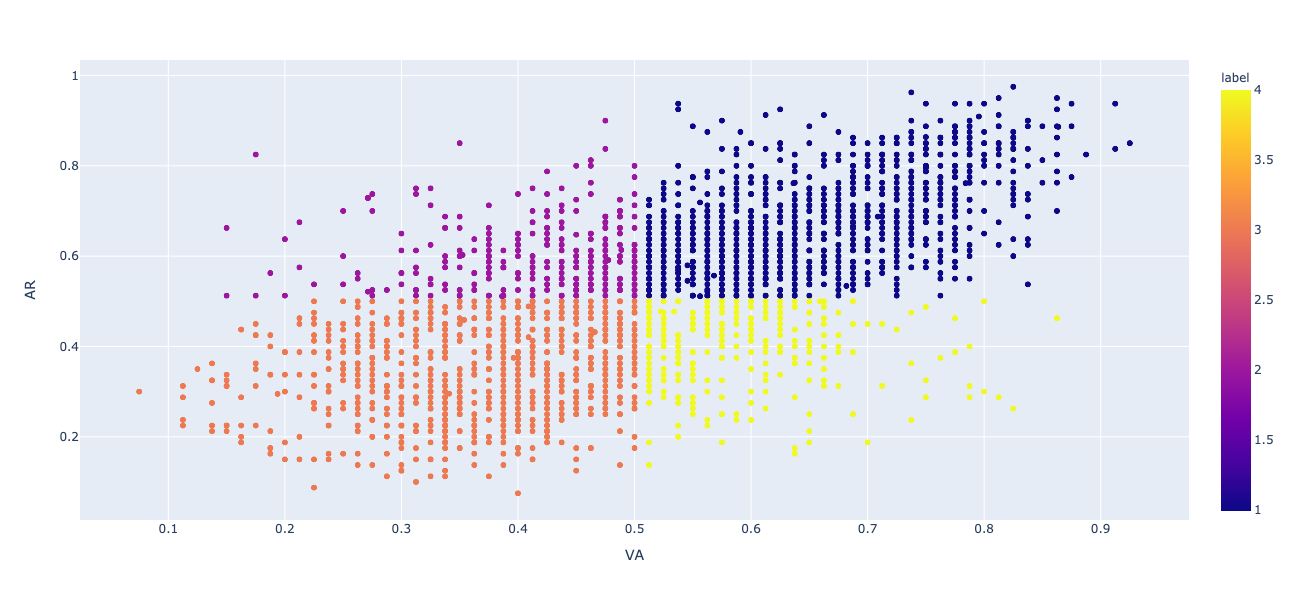

In [166]:
import plotly.express as px
fig = px.scatter(meta.dropna(), x="VA", y="AR", color="label" ,width=600, height=600)
fig.show()

<AxesSubplot:xlabel='label', ylabel='count'>

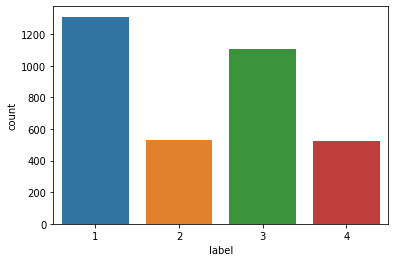

In [167]:
sns.countplot(x='label',data=meta)

In [168]:
meta.to_csv('./data/meta.csv')